In [1]:
import numpy as np
import tensorflow as tf
import tensorpack as tp

from tensorpack import dataset
from tensorpack.dataflow import imgaug, AugmentImageComponent, BatchData, PrefetchData
import tensorpack.tfutils.symbolic_functions as symbf

import tensorflow.contrib.slim as slim
from tensorflow.python.training import optimizer

class ModelCIFAR10_simple(object):
    def __init__(self, learning_rate=0.001, batch_size=128):
        self.batch_size = batch_size
        self.inputs = [
            tf.placeholder(tf.float32, shape=(None, 32, 32, 3)),
            tf.placeholder(tf.int32, shape=(None,))
        ]
        
        self.probability, self.cost, self.accuracy = self._build_graph(self.inputs)
        self.op = self._get_optimize_operator(self.cost, learning_rate)
        self.dataflow = {
            'train':self._get_data('train'),
            'valid':self._get_data('test'),
        }
        
    def _build_graph(self, inputs):
        image, label = inputs
        
        with slim.arg_scope([slim.layers.fully_connected], weights_regularizer=slim.l2_regularizer(1e-5)):
            l = slim.layers.conv2d(image, 32, [3, 3], scope='conv0')
            l = slim.layers.max_pool2d(l, [2, 2], scope='pool0')
            l = slim.layers.conv2d(l, 32, [3, 3], padding='SAME', scope='conv1')
            l = slim.layers.conv2d(l, 32, [3, 3], scope='conv2')
            l = slim.layers.max_pool2d(l, [2, 2], scope='pool1')
            l = slim.layers.conv2d(l, 32, [3, 3], scope='conv3')
            l = slim.layers.flatten(l, scope='flatten')
            l = slim.layers.fully_connected(l, 512, scope='fc0')
            logits = slim.layers.fully_connected(l, 10, activation_fn=None, scope='fc1')

        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')

        prob = tf.nn.softmax(logits, name='prob')
        accuracy = symbf.accuracy(logits, label, topk=1)
        return prob, cost, accuracy
    
    def _get_optimize_operator(self, cost, learning_rate=0.1):
        var_list = (tf.trainable_variables() + tf.get_collection(tf.GraphKeys.TRAINABLE_RESOURCE_VARIABLES))
        var_list += tf.get_collection(tf.GraphKeys._STREAMING_MODEL_PORTS)

        processors = [optimizer._get_processor(v) for v in var_list]
        var_refs = [p.target() for p in processors]
        
        # compute_gradients
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        grads_and_vars = list(zip(grads, var_list))
        
        self.grads = grads
        opt = tf.train.AdamOptimizer(learning_rate)
        return opt.apply_gradients(grads_and_vars)
    
    def _get_data(self, train_or_test):
        BATCH_SIZE = self.batch_size
        isTrain = train_or_test == 'train'
        ds = dataset.Cifar10(train_or_test)
        pp_mean = ds.get_per_pixel_mean()
        if isTrain:
            augmentors = [
                imgaug.CenterPaste((40, 40)),
                imgaug.RandomCrop((32, 32)),
                imgaug.Flip(horiz=True),
                imgaug.MapImage(lambda x: x - pp_mean),
            ]
        else:
            augmentors = [
                imgaug.MapImage(lambda x: x - pp_mean)
            ]
        ds = AugmentImageComponent(ds, augmentors)
        ds = BatchData(ds, BATCH_SIZE, remainder=not isTrain)
        if isTrain:
            ds = PrefetchData(ds, 3, 2)
        return ds

In [2]:
model = ModelCIFAR10_simple()

[1013 16:44:22 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[1013 16:44:22 @cifar.py:33] Found cifar10 data in /root/tensorpack_data/cifar10_data.
[1013 16:44:24 @cifar.py:33] Found cifar10 data in /root/tensorpack_data/cifar10_data.


In [3]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [4]:
import sklearn.preprocessing

history = []
for epoch in range(50):
    result = {}
    
    model.dataflow['train'].reset_state()
    step, costs, accuracies = 0, [], []
    for datapoint in model.dataflow['train'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        _, cost, accuracy, grads = sess.run([model.op, model.cost, model.accuracy, model.grads],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        grads = [np.sum(np.abs(g)) for g in grads]
        costs.append(cost)
        accuracies.append(accuracy)
        step += 1
        #print('[train] epoch:%04d step:%04d cost:%.3f accuracy:%0.2f'%(epoch, step, cost, accuracy))
    print('[%04d] [train] cost:%.3f accuracy:%0.2f'%(epoch+1, np.mean(costs), np.mean(accuracies)), end=' ')
    result['train'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies), 'grads_abs':grads}

    model.dataflow['valid'].reset_state()
    costs, accuracies = [], []
    for datapoint in model.dataflow['valid'].get_data():
        datapoint.append( sklearn.preprocessing.label_binarize( datapoint[1], range(10) ).astype(np.float32) )
        cost, accuracy = sess.run([model.cost, model.accuracy],
                                     feed_dict=dict(zip(model.inputs, datapoint)))
        costs.append(cost)
        accuracies.append(accuracy)
        
    print('[valid] cost:%.3f accuracy:%0.2f'%(np.mean(costs), np.mean(accuracies)))
    result['valid'] = {'epoch':epoch, 'cost':np.mean(costs), 'accuracy':np.mean(accuracies)}
    
    history.append( result )

[0001] [train] cost:2.082 accuracy:0.31 [valid] cost:1.580 accuracy:0.43
[0002] [train] cost:1.517 accuracy:0.45 [valid] cost:1.369 accuracy:0.52
[0003] [train] cost:1.366 accuracy:0.51 [valid] cost:1.268 accuracy:0.54
[0004] [train] cost:1.260 accuracy:0.55 [valid] cost:1.249 accuracy:0.56
[0005] [train] cost:1.176 accuracy:0.58 [valid] cost:1.091 accuracy:0.61
[0006] [train] cost:1.108 accuracy:0.61 [valid] cost:1.073 accuracy:0.62
[0007] [train] cost:1.053 accuracy:0.63 [valid] cost:1.038 accuracy:0.65
[0008] [train] cost:0.989 accuracy:0.66 [valid] cost:0.943 accuracy:0.68
[0009] [train] cost:0.946 accuracy:0.67 [valid] cost:0.914 accuracy:0.69
[0010] [train] cost:0.919 accuracy:0.68 [valid] cost:0.947 accuracy:0.68
[0011] [train] cost:0.877 accuracy:0.69 [valid] cost:0.855 accuracy:0.71
[0012] [train] cost:0.852 accuracy:0.70 [valid] cost:0.861 accuracy:0.71
[0013] [train] cost:0.826 accuracy:0.71 [valid] cost:0.836 accuracy:0.72
[0014] [train] cost:0.820 accuracy:0.72 [valid] cos

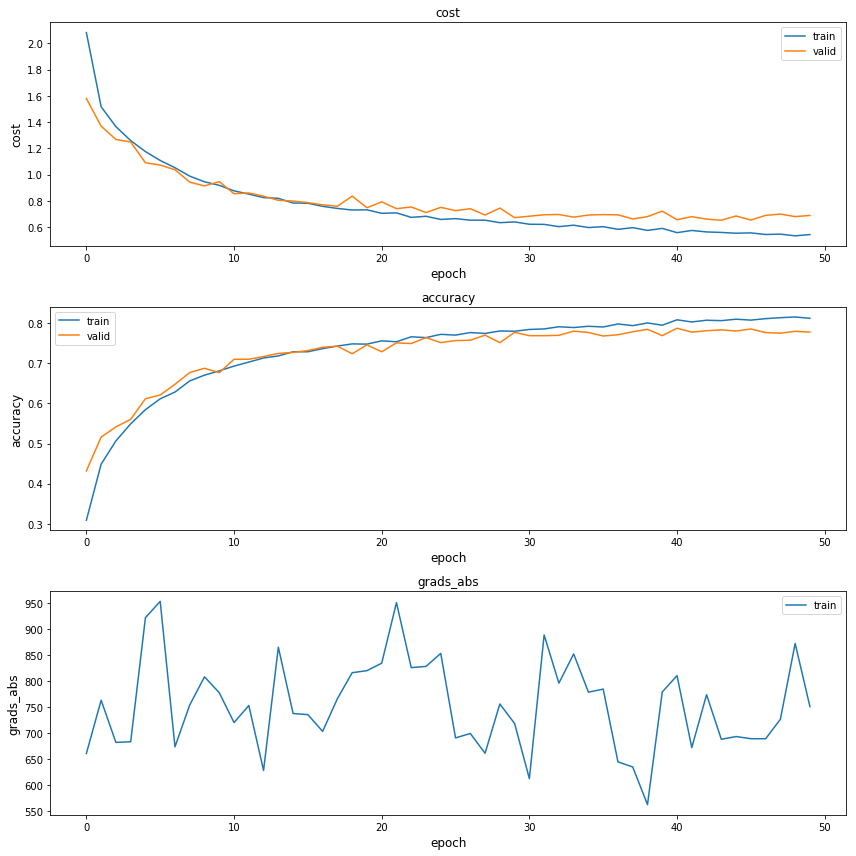

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(12, 4*3))
for i, label in enumerate(['cost', 'accuracy', 'grads_abs']):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_xlabel('epoch', fontsize=12)
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(label, fontsize=12)
    for j, mode in enumerate(['train', 'valid']):
        if not label in history[0][mode]:
            continue
        ax.plot(np.array([h[mode]['epoch'] for h in history]), np.array([np.sum(h[mode][label]) for h in history]), label=mode)
    ax.legend()
plt.tight_layout()